In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import pubchempy as pcp
import numpy as np
import glob
import os
from moleculegraph.molecule_utils import *
from moleculegraph.funcs import *
import moleculegraph
import scipy

In [17]:
group = "alkanes"

name="butane"
smiles ="CCCC"
molecule_graphstring = "[CH3_alkane][CH2_alkane][CH2_alkane][CH3_alkane]"

name="dimethylether"
smiles ="COC"
molecule_graphstring = "[CH3_alkane][O_dme][CH3_alkane]"


group = "alcohols"

name="butanol"
smiles ="OCCC"
molecule_graphstring = "[cH_alcohol][OH_alcohol][CH2_alcohol][CH2_alkane][CH2_alkane][CH3_alkane]"

name="propanol"
smiles ="OCCC"
molecule_graphstring = "[cH_alcohol][OH_alcohol][CH2_alcohol][CH2_alkane][CH3_alkane]"

name="ethanol"
smiles ="OCC"
molecule_graphstring = "[CH3][CH2][OH]"

group = "diols"
name= "1.2-Ethanediol"
smiles ="C(CO)O"
molecule_graphstring = "[cH_alcohol][OH_alcohol][CH2_alcohol][CH2_alcohol][OH_alcohol][cH_alcohol]"

#name= "1.3-Propanediol"
#smiles = "C(CO)CO"
#molecule_graphstring = "[cH_alcohol][OH_alcohol][CH2_alcohol][CH2_alkane][CH2_alcohol][OH_alcohol][cH_alcohol]"

#name= "1.4-Butanediol"
#smiles = "C(CCO)CO"
#molecule_graphstring = "[cH_alcohol][OH_alcohol][CH2_alcohol][CH2_alkane][CH2_alkane][CH2_alcohol][OH_alcohol][cH_alcohol]"

#name= "1.5-Pentanediol"
#smiles = "C(CCO)CCO"
#molecule_graphstring = "[cH_alcohol][OH_alcohol][CH2_alcohol][CH2_alkane][CH2_alkane][CH2_alkane][CH2_alcohol][OH_alcohol][cH_alcohol]"

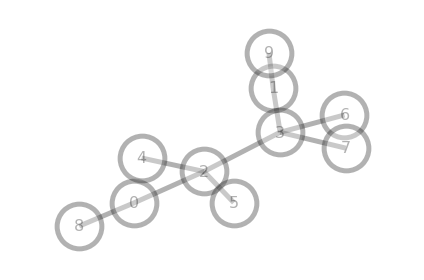

In [18]:
os.makedirs( group+"/xyz_files",exist_ok=True )

#Get Molecule via Pupchem
molecule = pcp.get_compounds(smiles, "smiles", record_type='3d')[0]

atoms = []
atom_names = []
for a in molecule.atoms:
    atoms.append( [a.x,a.y,a.z]) #xyz_files for molecule
    atom_names.append(a.element) #atom name

bond_list = []
for bond in molecule.bonds:
    bond_list.append( [bond.aid1,bond.aid2] ) #Bondlist
    
graph  = nx.Graph()
for b0,b1 in bond_list:
    graph.add_edge(b0-1,b1-1)

options = {
    "node_size": 2000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
    #"with_labels":True,
    "alpha":.3,
    "font_size":16,
}
labels = {}


pos = nx.spring_layout(graph)

nx.draw_networkx(graph, **options)
nx.draw_networkx_labels(graph, pos , labels, font_size=12, font_color="black")

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.tight_layout()

#plt.savefig(name+".png")
plt.show()

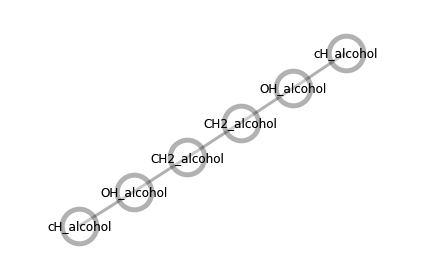

In [19]:
raw_molecule = moleculegraph.molecule(molecule_graphstring)
raw_molecule.visualize()

In [22]:
def adjust_bond_list_indexes(bond_list):
    old = np.unique( cleaned_bond_list.flatten() ) #mache aus matrix array in dem jeder index nur 1 mal vorkommt
    new = np.arange( old.size )                    #vektor mit 0,1,2,... bis size old
    new_list = np.ones( bond_list.shape ) * -1     #matrix
    for i,j in zip(old,new):
        new_list[ bond_list == i ] = j             #überschreibe eintrag mit wert aus vektor
    return new_list , old, new


bond_list = []
atomtypes = []

for bond in molecule.bonds:

    i = bond.aid1-1                                #beginne bei 0 statt 1
    j = bond.aid2-1
    bond_list.append( [ i,j] )
    atomtypes.append( [ molecule.atoms[i].element, molecule.atoms[j].element ] )
    
bond_list = np.array(bond_list) #Bondliste
atomtypes = np.array(atomtypes) #Namen der Bonds

distances = []
cleaned_bond_list = []
cleaned_atomtypes = []
atoms = np.array(atoms)


for (b0,b1),(a0,a1) in zip( bond_list, atomtypes):                #Schreibe die United Atoms raus (entferne alle H's)

    if "H" in (a0,a1) and "C" in (a0,a1): #or "O" in (a0,a1)):
        hydrogen = np.array([b0, b1])[ np.array([a0,a1]) == "H" ] #[.. = "H"] checkt ob H in Array --> returned Vektor mit ["true","false",...]
        print("C + H detected")                                   #np.array([b0,b1])["true",..] gibt nur die werte aus [b0,b1] die H sind
        if bond_list[ bond_list == hydrogen ].size == 1:          #schaut wo hydrogen in bond list vorkommt, wenn nur ein Eintrag dann mache nichts
            print("continue")                                     #continue überspringt restliche befehle in Schleife und geht in nächste Iteration
            continue
    print( "keep",b0,b1,"->",a0,"--",a1 )        
    cleaned_bond_list.append( (b0,b1) )
    cleaned_atomtypes.append( (a0,a1) )

cleaned_bond_list = np.array(cleaned_bond_list)

p = np.unique(cleaned_bond_list).astype(int) #vektor nur mit indizes der Bindungen [0,1,2,...]

cleaned_bond_list, old_indexes, new_indexes = adjust_bond_list_indexes(cleaned_bond_list)

cleaned_xyz_files = np.array(atoms)[p]      #Matrix mit Koordinaten der C Atome als zeilen
cleaned_atomtypes   = np.array(atom_names)[p] #Array mit C Atomen

distance_matrix, _ = get_distance_matrix( cleaned_bond_list, np.unique( cleaned_bond_list.flatten() ).size )

final_xyz_files, indexes = moleculegraph.assign_coos_via_distance_mat(
    cleaned_xyz_files,distance_matrix,raw_molecule.distance_matrix)
final_atom_names = cleaned_atomtypes[indexes]

f = open( group + "/xyz_files/" + name+".xyz", "w")
f.write(str(len(final_atom_names))+"\n")
f.write("\n")
for aname,xyz in zip(final_atom_names,final_xyz_files):
    line = "    ".join([aname]+[ str(y) for y in xyz ])
    f.write(line+"\n")
f.close()

f = open(group + "/xyz_files/" + name+"_test.xyz", "w")
f.write(str(len(final_atom_names))+"\n")
f.write("\n")
for aname,xyz in zip(final_atom_names,final_xyz_files):
    line = "    ".join([aname]+[ str(y) for y in xyz ])
    f.write(line+"\n")
f.close()

f = open( group + "/xyz_files/" + name+"_playmol.xyz", "w")
f.write(str(len(final_atom_names))+"\n")
f.write("\n")
for aname,xyz in zip(final_atom_names,final_xyz_files):
    line = "    ".join([aname]+[ str(y) for y in xyz ])
    f.write(line+"\n")
f.close()
    
#write playmol coos
print("no xyz coos are saved in inout_playmol")
print("file ", "molecule_xyz/"+name+"_playmol.xyz", "needs to be created" )
print("...based on ",group + "/xyz_files/","*")
print("the order of the atoms in the xyz file must match the graph or the graph string")
print("")
#f = open("inout_playmol/"+name+"_playmol.xyz", "w")
#f.write(str(len(final_atom_names))+"\n")
#f.write("\n")
#for i,xyz in enumerate(final_xyz_files):
#    line = "    ".join(["A"+str(i+1)]+[ str(y) for y in xyz ])
#    f.write(line+"\n")
#f.close()

print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
print("adjust atomnames in ", "molecule_xyz/"+name+"_playmol.xyz")
print("...because assign_coos_via_distance_mat might be wrong")
print("")
print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

keep 0 2 -> O -- C
keep 0 8 -> O -- H
keep 1 3 -> O -- C
keep 1 9 -> O -- H
keep 2 3 -> C -- C
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue


    Assign_coos_via_distance_mat is not mature yet.
    In branched molecules errors are conceivable because atom elements are not checked.

    In structurally symmetric molecules with non-symmetric atome types errors might occur 

    Double-check your results!!! 
 

no xyz coos are saved in inout_playmol
file  inout_playmol/1.2-Ethanediol_playmol.xyz needs to be created
...based on  diols/xyz_files/ *
the order of the atoms in the xyz file must match the graph or the graph string

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
adjust atomnames in  inout_playmol/1.2-Ethanediol_playmol.xyz
...because assign_coos_via_distance_mat might be wrong

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
